In [1]:
%matplotlib inline

import os
import glob

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import ListedColormap

import imageio
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter

# Plot hetmaps over selected frame without data from rejected sessions.

In [2]:
def get_data(mediafile):
    try:
        coordinates = np.load("../export/coordinates_data_without_bad_session_{}.npy".format(mediafile))
        fixations = np.load("../export/fixations_data_without_bad_session_{}.npy".format(mediafile))
        return coordinates, fixations
    except:
        print("No stored files found.. load from files first")

In [3]:
mediafile = 69
media = imageio.get_reader("../Dataset/Mahnob/data/media_24/{}.avi".format(mediafile))
coordinates, fixations = get_data(mediafile)

In [7]:
DISPLAY_SIZE = (320,200)

def get_media_frame(media, frames):
    images = []
    for frame in frames:
        media.set_image_index(frame-1)
        images.append(media.get_next_data())
    return images

def get_start_stop(frame):
    fps = 1
    start = fps * frame
    stop = start + fps
    return start, stop

def get_gaze_data(data, frame):
    start, stop = get_start_stop(frame)
    return data[start:stop]

def get_frame_coordinates(coord, frames):
    frame_coordinates = []
    for frame in frames:
        frame_coordinates.append(get_gaze_data(coord, frame))
    return frame_coordinates

def get_frame_fixations(fix, frames):
    frame_fixations = []
    for frame in frames:
        frame_fixations.append(get_gaze_data(fix, frame))
    return frame_fixations

def normalize(data):
    return ( data - data.min()) / ( data.max() - data.min() )

def normalize_fixations_duration(fix):
    fix[:,:,2] /= fix[:,:,2].max()
    #fixations[:,:,2] = normalize(fixations[:,:,2])
    return fix

def compute_frame_saliency_map(data, normed=False):
    
    ### MOD 1
    
#     data = data.squeeze()
    
#     x, y, d = data.T
    
#     heatmap, xedges, yedges = np.histogram2d(x, y, weights=1000*d, bins=DISPLAY_SIZE)
#     extent = [0, DISPLAY_SIZE[0], 0, DISPLAY_SIZE[1]]
#     print(np.where(heatmap != 0))
#     return heatmap, extent
    
    ### MOD 2
    
    ## matrix of zeros
    M = np.zeros([DISPLAY_SIZE[1], DISPLAY_SIZE[0]], dtype=float)
    extent = [0, DISPLAY_SIZE[0], DISPLAY_SIZE[1], 0]
    # gaussian matrix
    for x, y, d in data.squeeze():
        if 0<=x<=DISPLAY_SIZE[0] and 0<=y<=DISPLAY_SIZE[1]:
            M[int(y), int(x)] = d
    M = gaussian_filter(M, sigma=8)
    return M, extent

    ### MOD 3
    
#     k = gaussian_kde(data.squeeze().T)
#     xi, yi = np.mgrid[0:320:320*1j, 0:200:200*1j]
#     zi = k(np.vstack([xi.flatten(), yi.flatten()]))
#     zi = zi.reshape(xi.shape)
#     return xi, yi, zi
    
    

def get_frame_saliency_maps(gaze_data, frames):
    frame_saliency_maps = []
    for frame in frames:
        gd = get_gaze_data(gaze_data, frame)
        frame_saliency_maps.append(compute_frame_saliency_map(gd, frame))
    return frame_saliency_maps

##
## PLOT FUNCTIONS
##

def create_axes(sub=(1,1)):
    
    dpi = 100
    ncols=sub[0]
    nrows=sub[1]
    # determine the figure size in inches
    figsize = (1280*ncols/dpi, 800*nrows/dpi)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi)
    
    extent = [0, DISPLAY_SIZE[0], DISPLAY_SIZE[1], 0]

    if not isinstance(axes, type(np.array)): 
        axes = np.array(axes) 
    
    for ax in axes.flatten(): 
        ax.axis(extent)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    return axes.flatten()

def plot_images(axes, frames):
    images = get_media_frame(media, frames)
    for ax, im in zip(axes, images):
        ax.imshow(im, origin='lower')
    
def plot_coordinates(axes, data, frames):
    frame_coordinates = get_frame_coordinates(data, frames)
    for ax, c in zip(axes, frame_coordinates):
        x, y = c.T
        ax.scatter(x, y, s=10, alpha=.8)

def plot_fixations(axes, data, frames):
    frame_fixations = get_frame_fixations(data, frames)
    for ax, fix in zip(axes, frame_fixations):
        x, y, d = fix.T
        ax.scatter(x, y, s=100*d, alpha=.8, c='orange')
        
def plot_saliency_map(axes, data, frames):
    cmap = cm.jet
    my_cmap = cmap(np.arange(cmap.N))

    # Set alpha
    my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

    # Create new colormap
    cm_jet = ListedColormap(my_cmap)
    
    frame_saliency_maps = get_frame_saliency_maps(data, frames)
    for ax, (heatmap, extent) in zip(axes, frame_saliency_maps):
        ax.imshow(heatmap, extent=extent, cmap=cm_jet, alpha=.8)
    #for ax, (xi, yi, zi) in zip(axes, frame_saliency_maps):
    #    ax.pcolormesh(xi, yi, zi, shading='gouraud', cmap="jet", alpha=.1)

In [5]:
fixations = normalize_fixations_duration(fixations)

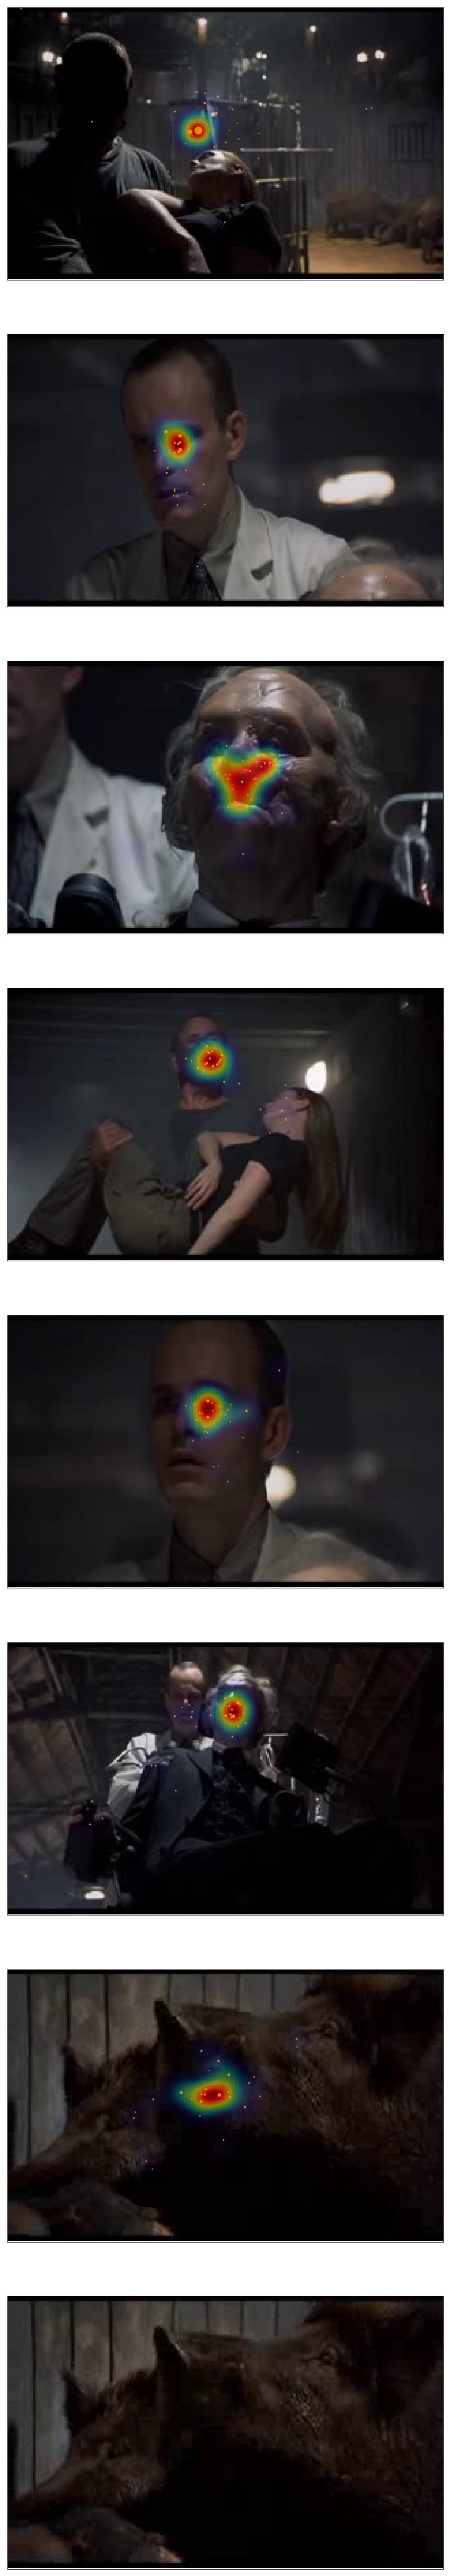

In [8]:
frames = [1, 100, 200, 300, 400, 500, 1000, 1500]
col = 1
axes = create_axes((col,len(frames)//col))
plot_images(axes, frames)
#plot_coordinates(axes, coordinates, frames)
plot_fixations(axes, fixations, frames)
plot_saliency_map(axes, fixations, frames)